In [1]:
# SETUP

import contextlib
import pathlib
import shutil
import subprocess

src_dir = pathlib.Path("stored_workflows")
json_files = [f.name for f in src_dir.glob("*.json")]

for name in json_files:
    shutil.copy(src_dir / name, pathlib.Path("."))

subprocess.run(["../../local_postgres.zsh", "stop"])
subprocess.run(["../../local_postgres.zsh", "remove"])
subprocess.run(["../../local_postgres.zsh", "init"])
subprocess.run(["../../local_postgres.zsh", "start"])

waiting for server to shut down.... done
server stopped
Removed ./.pycor/pgdata
The files belonging to this database system will be owned by user "liamhuber".
This user must also own the server process.

The database cluster will be initialized with this locale configuration:
  locale provider:   libc
  LC_COLLATE:  C
  LC_CTYPE:    UTF-8
  LC_MESSAGES: C
  LC_MONETARY: C
  LC_NUMERIC:  C
  LC_TIME:     C
The default database encoding has accordingly been set to "UTF8".
The default text search configuration will be set to "simple".

Data page checksums are disabled.

fixing permissions on existing directory .pycor/pgdata ... ok
creating subdirectories ... ok
selecting dynamic shared memory implementation ... posix
selecting default "max_connections" ... 100
selecting default "shared_buffers" ... 128MB
selecting default time zone ... America/Vancouver
creating configuration files ... ok
running bootstrap script ... ok
performing post-bootstrap initialization ... 

initdb: could not find suitable text search configuration for locale "UTF-8"


ok
syncing data to disk ... ok


Success. You can now start the database server using:

    pg_ctl -D ./.pycor/pgdata -l logfile start

waiting for server to start.... done
server started


initdb: warning: enabling "trust" authentication for local connections
initdb: hint: You can change this by editing pg_hba.conf or using the option -A, or --auth-local and --auth-host, the next time you run initdb.


waiting for server to shut down.... done
server stopped
waiting for server to start.... done
server started


CompletedProcess(args=['../../local_postgres.zsh', 'start'], returncode=0)

In [2]:
%config IPCompleter.evaluation='unsafe'

from pyiron_workflow.graph import gui, base

In [3]:
pf = gui.PyironFlow(['murnaghan2', 'energy', 'murn4', 'db']) # 'landau2',
pf.gui

In [4]:
import pyiron_database.instance_database as idb

# MUST ENSURE `'murn4'` graph is the active one -- how to do this with code?
# We could go back and manually change the order they are loaded in,
# but I want to see what is required to actually select one
def select_graph_by_name(pf: gui.PyironFlow, graph_label: str):
    pf.tab_widget.selected_index = [w.graph.label for w in pf.wf_widgets].index(graph_label)

select_graph_by_name(pf, "murn4")

graph = pf.graph
graph = base.update_execution_graph(graph, debug=True)
nodeB = graph.nodes["BulkStaticEnergyF"].node
nodeI = graph.nodes["IterNode"].node

idb.get_hash(nodeB), id(nodeB), id(nodeI.inputs.node.value.node)



  

Updating input BulkStaticEnergyF in node BulkStaticEnergyF out node 6253165168 6253165168
Updating input Linspace in node Linspace linspace kwarg_list 6253396432 6253396432
Updating input CreateDB in node CreateDB db _db 6253397872 6253397872
Updating input CreateDB in node CreateDB db _db 6253397872 6253397872
Updating input CreateDB in node CreateDB db db 6253397872 6253397872


('53ac213be901c9c01914b0184ad75b68bed31310fdbf559557cc1a9fce9e025d',
 6253165168,
 6253165168)

In [5]:
id(nodeB.outputs.out.node), id(nodeB)

(6253165168, 6253165168)

In [6]:
nodeI.outputs.data.keys()

dict_keys(['label', 'type', 'ready', 'value', 'node'])

In [7]:
nodeB.inputs

,label,type,default,ready,value,node
0,name,str,NotData,True,Al,<pyiron_workflow.simple_workflow.Node object a...
1,a,float,None,True,None,<pyiron_workflow.simple_workflow.Node object a...
2,store,bool,True,True,True,<pyiron_workflow.simple_workflow.Node object a...
3,_db,None,None,True,label ...,<pyiron_workflow.simple_workflow.Node object a...


In [8]:
nodeI.inputs.node.value

label                                                  out
type                                     builtins.NoneType
ready                                                False
value                                                 None
node     <pyiron_workflow.simple_workflow.Node object a...
dtype: object

In [9]:
idb.get_hash(nodeI.inputs.node.value.node)

'53ac213be901c9c01914b0184ad75b68bed31310fdbf559557cc1a9fce9e025d'

In [10]:
 nodeI.inputs.node.value.node.inputs

,label,type,default,ready,value,node
0,name,str,NotData,True,Al,<pyiron_workflow.simple_workflow.Node object a...
1,a,float,None,True,None,<pyiron_workflow.simple_workflow.Node object a...
2,store,bool,True,True,True,<pyiron_workflow.simple_workflow.Node object a...
3,_db,None,None,True,label ...,<pyiron_workflow.simple_workflow.Node object a...


In [11]:
base._find_input_nodes(base._remove_node_inputs(graph), 1)

[2, 3, 1]

In [12]:
from pyiron_workflow.simple_workflow import extract_output_parameters_from_function, _return_as_macro_node

In [13]:
import pyiron_nodes as pn

pn.local_workflows.test.BulkStaticEnergy

<function pyiron_nodes.local_workflows.test.BulkStaticEnergy(name: str, a: float = None, store: bool = True, _db=None) -> float>

In [14]:
from pyiron_workflow import as_macro_node, as_function_node, Node, Port

@as_function_node("energy")
def BulkStaticEnergy(name: str, a: float = None):

    from pyiron_workflow import Workflow
    import pyiron_nodes

    wf = Workflow('subgraph')

    wf.Bulk = pyiron_nodes.atomistic.structure.build.Bulk(name=name, a=a) 
    wf.M3GNet = pyiron_nodes.atomistic.engine.ase.M3GNet() 
    wf.Static = pyiron_nodes.atomistic.calculator.ase.Static(structure=wf.Bulk, engine=wf.M3GNet) 
    wf.GetEnergyLast = pyiron_nodes.atomistic.calculator.output.GetEnergyLast(calculator=wf.Static) 

    out = wf.GetEnergyLast.pull()

    return out

    # return wf.GetEnergyLast.outputs.energy_last

In [15]:
@as_macro_node(["BulkStaticEnergy", "BulkStructure"])
def BulkStaticEnergy(name: str, a: float = None):

    from pyiron_workflow import Workflow
    import pyiron_nodes

    wf = Workflow('subgraph')

    wf.Bulk = pyiron_nodes.atomistic.structure.build.Bulk(name=name, a=a) 
    wf.M3GNet = pyiron_nodes.atomistic.engine.ase.M3GNet() 
    wf.Static = pyiron_nodes.atomistic.calculator.ase.Static(structure=wf.Bulk, engine=wf.M3GNet) 
    wf.GetEnergyLast = pyiron_nodes.atomistic.calculator.output.GetEnergyLast(calculator=wf.Static) 

    return wf.GetEnergyLast.outputs.energy_last, wf.Bulk

In [16]:
args = ["BulkStaticEnergy", "BulkStructure"]
# print("args", args, isinstance(args[0], str))
if isinstance(args[0], str):
    output_labels = list(args)
else:
    output_labels = None
output_labels

['BulkStaticEnergy', 'BulkStructure']

In [17]:
out = BulkStaticEnergy(name='Al').run()
out
#isinstance(out, Port)
#out.node._workflow.run()
# out._workflow.run()
# _return_as_macro_node(BulkStaticEnergy('Al'), 'Bulk', 'Energy', 'macro')

/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.element_refs = AtomRef(property_offset=torch.tensor(element_refs, dtype=matgl.float_th))
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("data_mean", torch.tensor(data_mean, dtype=matgl.float_th))
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().require

(-3.701530933380127,
 Al: [0. 0. 0.]
 tags: 
     indices: [0]
 pbc: [ True  True  True]
 cell: 
 Cell([[0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]]))

In [18]:
select_graph_by_name(pf, "murnaghan2")
pf.graph.nodes["subgraph"].node.node_type

'graph'

In [19]:
base.get_inputs_of_graph(pf.graph.nodes["subgraph"].graph, exclude_unconnected_default_ports=True)

,label,value,type,default,ready
0,Bulk__name,Al,str,NotData,True
1,Bulk__a,2,float,None,True


In [20]:
print(base.get_code_from_graph(pf.graph.nodes["subgraph"].graph))


def subgraph(name: str, a: float = None):

    from pyiron_workflow import Workflow
    import pyiron_nodes

    wf = Workflow('subgraph')

    wf.Bulk = pyiron_nodes.atomistic.structure.build.Bulk(name=name, a=a) 
    wf.M3GNet = pyiron_nodes.atomistic.engine.ase.M3GNet() 
    wf.Static = pyiron_nodes.atomistic.calculator.ase.Static(structure=wf.Bulk, engine=wf.M3GNet) 
    wf.GetEnergyLast = pyiron_nodes.atomistic.calculator.output.GetEnergyLast(calculator=wf.Static) 

    return wf.GetEnergyLast.outputs.energy_last



In [21]:
# db  # NameError: name 'db' is not defined

From here on, we need the database to actually be populated with results from our workflows. Since this is not part of our static data, obtain it by simply re-running each of the existing workflows.

In [22]:
def pull_all_terminal_nodes(graph: base.Graph, _verbose: bool = False):
    graph_copy = base.get_updated_graph(graph)
    for label, graph_node in graph_copy.nodes.items():
        is_virtual = (
            graph_node.node_type != "node" # Is this true? Is a "graph" node_type always virtual?
            and graph_node.node is not None  # These are virtual IO nodes
        )
        is_terminal = label not in graph.edges.df["source"].values
        
        if is_terminal and not is_virtual:
            if _verbose:
                print("Pulling", label)
            base.pull_node(graph_copy, label)

for wfw in pf.wf_widgets:
    if wfw.graph.label == "db":
        # The GetGraph node of this workflow fails for the stored "node_id" of 20
        # It also fails if I go back and set this to 0
        # I don't know what should be in the database at this point, but it isn't
        continue
    print("Ensuring execution for", wfw.graph.label)
    pull_all_terminal_nodes(wfw.graph)

/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.element_refs = AtomRef(property_offset=torch.tensor(element_refs, dtype=matgl.float_th))
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("data_mean", torch.tensor(data_mean, dtype=matgl.float_th))
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().require

Ensuring execution for murnaghan2
Running node Linspace
Running node CreateDB
Running node IterNode
Restoring node outputs  9bd7911eb91f5326720e2753be05f5fde5a2edef5bc7c0d66e12817ffb145501 False
No stored data found for node:  IterNode
copy node (port):  subgraph fb6471b1fc8bd5750d43fac2f3f132e61276aec65b34f665550cafe024c01e2a


DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.element_refs = AtomRef(property_offset=torch.tensor(element_refs, dtype=matgl.float_th))
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("data_mean", torch.tensor(data_mean, dtype=matgl.float_th))
/U

serialization needed
stored:  IterNode .storage/10cbd2c7503397244d3b8ba7eda766aca96cb845aee39ea8904fd6336df60979.hdf5
Running node CreateDB
Running node ShowTable
Ensuring execution for energy
Running node Bulk
Running node M3GNet
Running node CreateDB
Running node Static
Running node GetEnergyLast
serialization not needed
stored:  GetEnergyLast .storage/9288d0ad5c831775093dab6a9f2e1a7100f6ab7d3e6c4220ddbacf4fb809d386.hdf5
Running node CreateDB
Running node ShowTable
Ensuring execution for murn4
Running node Linspace
Running node CreateDB
Running node IterNode
Restoring node outputs  f5acb73836985369d523b5587504f9860c2fe7ce84c027e6f2d2ffb6e655a28d False
No stored data found for node:  IterNode
copy node (port):  BulkStaticEnergyF 53ac213be901c9c01914b0184ad75b68bed31310fdbf559557cc1a9fce9e025d
Restoring node outputs  2ce3c3a3d5a648f7bd704d950f60cc384fe8caa26f9624777782003cd273dffc True
return original object
restored:  True
Restoring node outputs  276310e6b46125c446f61274ed951cd5865925

In [23]:
select_graph_by_name(pf, "murn4")
pf.graph.nodes["ShowTable"].node.outputs.df.value.iloc[7].hash

'9288d0ad5c831775093dab6a9f2e1a7100f6ab7d3e6c4220ddbacf4fb809d386'

In [24]:
from pyiron_database.instance_database import restore_node_from_database, PostgreSQLInstanceDatabase
from sqlalchemy.orm import sessionmaker
import pandas as pd

user = 'localuser'
password = 'none'
host = 'localhost'
port = '5432'
database = 'localdb'

connection_str = f'postgresql://{user}:{password}@{host}:{port}/{database}'
db = PostgreSQLInstanceDatabase(connection_str)
# db.drop()  # But if we do this, we lose all our data?!
# db.init()



In [25]:
Session = sessionmaker(bind=db.engine)
session = Session()

df = pd.read_sql(session.query(db.table).statement, session.bind)

session.close()

_, graph = restore_node_from_database(db=db, node_hash=df.hash.iloc[6]) #[19])
#_, graph = restore_node_from_database(db=db, node_hash='cf0bda97885d0ddf6b8a4cd1a92d38806147e0721a9f646cfb3a37487dd6a7b2')
base.GuiGraph(graph)

ReactFlowWidget(layout=Layout(height='600px', width='800px'))

In [26]:
df

,hash,qualname,module,version,connected_inputs,inputs,outputs,output_path,master_hash,start_time,cpu_time,executor,user
0,39669a289cc8b85c2e0774812b662253c661d306ef02d9...,subgraph,pyiron_workflow.graph.base,not_defined,[],"{'Bulk__a': 2.2, 'Bulk__name': 'Al'}",[GetEnergyLast__energy_last],None,fb6471b1fc8bd5750d43fac2f3f132e61276aec65b34f6...,2025-05-16 07:14:07.262268,0.046401,None,liamhuber
1,11e5f779d5a00821a3a28813c8cdb0c83a38c1fedce8e6...,Linspace,pyiron_nodes.math,not_defined,[],"{'x_max': 2.2, 'x_min': 1.8, 'endpoint': True,...",[linspace],None,None,2025-05-16 07:14:06.755304,0.000044,None,liamhuber
2,64667395d1b66a8a0ef131b4bade730b217b32465b813b...,CreateDB,pyiron_nodes.databases.node_hash_db,not_defined,[],"{'host': 'localhost', 'port': 5432, 'user': 'l...",[db],None,None,2025-05-16 07:14:06.755361,0.052682,None,liamhuber
3,10cbd2c7503397244d3b8ba7eda766aca96cb845aee39e...,IterNode,pyiron_nodes.executors,not_defined,"[node, kwarg_list, _db]",{'_db': '64667395d1b66a8a0ef131b4bade730b217b3...,[df],None,None,2025-05-16 07:14:06.833727,0.475070,None,liamhuber
4,7b4123d2f2ee2e9877493b62f6becb05f0483761d43031...,Bulk,pyiron_nodes.atomistic.structure.build,not_defined,[],"{'a': None, 'c': None, 'u': None, 'name': 'Al'...",[structure],None,None,2025-05-16 07:14:07.322326,0.000190,None,liamhuber
5,635cc10c63f0d96564a0eeb790d4adf102485cc41e475f...,M3GNet,pyiron_nodes.atomistic.engine.ase,not_defined,[],{'model': 'M3GNet-MP-2021.2.8-PES'},[out],None,None,2025-05-16 07:14:07.322527,0.017258,None,liamhuber
6,29624f6695f9b692420ba8f88e6a7965fff1347d9148b9...,Static,pyiron_nodes.atomistic.calculator.ase,not_defined,"[structure, engine]",{'engine': '635cc10c63f0d96564a0eeb790d4adf102...,[out],None,None,2025-05-16 07:14:07.345584,0.010043,None,liamhuber
7,9288d0ad5c831775093dab6a9f2e1a7100f6ab7d3e6c42...,GetEnergyLast,pyiron_nodes.atomistic.calculator.output,not_defined,"[calculator, _db]",{'_db': '64667395d1b66a8a0ef131b4bade730b217b3...,[energy_last],None,None,2025-05-16 07:14:07.355673,0.004245,None,liamhuber
8,44b1dc2862608dd3150b77d8efcbba02be1ec99a6f328d...,BulkStaticEnergyF,pyiron_nodes.local_workflows.test,not_defined,[_db],"{'a': 7.0, '_db': '64667395d1b66a8a0ef131b4bad...",[out],None,53ac213be901c9c01914b0184ad75b68bed31310fdbf55...,NaT,NaN,None,None
9,ca2abd5b485ed9f04818939a438372a82cbf297e1243e6...,Linspace,pyiron_nodes.math,not_defined,[],"{'x_max': 7, 'x_min': 3, 'endpoint': True, 'nu...",[linspace],None,None,2025-05-16 07:14:07.373371,0.000033,None,liamhuber


In [27]:
# df.query("hash == '9c051a26834ef83bbbe6c11c9fc0fc8c24cc06229432d31021fd00faa4c738ef'").iloc[0]
# Couldn't find that hash
some_valid_hash = df["hash"].iloc[0]
df.query(f"hash == '{some_valid_hash}'").iloc[0]

hash                39669a289cc8b85c2e0774812b662253c661d306ef02d9...
qualname                                                     subgraph
module                                     pyiron_workflow.graph.base
version                                                   not_defined
connected_inputs                                                   []
inputs                           {'Bulk__a': 2.2, 'Bulk__name': 'Al'}
outputs                                  [GetEnergyLast__energy_last]
output_path                                                      None
master_hash         fb6471b1fc8bd5750d43fac2f3f132e61276aec65b34f6...
start_time                                 2025-05-16 07:14:07.262268
cpu_time                                                     0.046401
executor                                                         None
user                                                        liamhuber
Name: 0, dtype: object

In [28]:
# df[df.hash==inputs["node"].split("@")[0]].iloc[0]
# NameError: name 'inputs' is not defined

In [29]:
# button
# NameError: name 'button' is not defined

In [30]:
import pyiron_nodes as pn
from pyiron_workflow.simple_workflow import get_import_path_from_type

pn.atomistic.structure.build.Bulk('Al')._func.__qualname__

'Bulk'

In [31]:
import pandas as pd

select_graph_by_name(pf, "murn4")
df = pf.graph.nodes["IterNode"].node.outputs.df.value
state = df.__getstate__()
print(state)

df_new = pd.DataFrame() # .__setstate__(state)
df_new._mgr = state["_mgr"]
df_new._metadata = state["_metadata"]
df_new2 = pd.DataFrame()
df_new2.__setstate__(state)
df_new2

{'_mgr': BlockManager
Items: Index(['a', 'result'], dtype='object')
Axis 1: RangeIndex(start=0, stop=7, step=1)
NumpyBlock: slice(0, 2, 1), 2 x 7, dtype: float64, '_typ': 'dataframe', '_metadata': [], 'attrs': {}, '_flags': {'allows_duplicate_labels': True}}


,a,result
0,3.000000,2.528607
1,3.666667,-3.223616
2,4.333333,-3.567102
3,5.000000,-2.563248
4,5.666667,-0.607272
5,6.333333,0.184764
6,7.000000,-0.148894


In [32]:
node = pf.graph.nodes["IterNode"].node

In [33]:
from sqlalchemy import create_engine, inspect, text
from sqlalchemy.orm import sessionmaker

user = 'localuser'
password = 'none'
host = 'localhost'
port = '5432'
database = 'localdb'

connection_str = f'postgresql://{user}:{password}@{host}:{port}/{database}'
engine = create_engine(connection_str)
engine.connect()

inspector = inspect(engine)
table_names = inspector.get_table_names()
table_names

['nodes']

In [34]:
import pyiron_database.instance_database as idb

node = pf.graph.nodes["IterNode"].node

db = idb.PostgreSQLInstanceDatabase(connection_str)
# db.drop()
# db.init()
# hash = idb.store_node_in_database(db, node, store_outputs=True, store_input_nodes_recursively=True)
# Gets a pickle complaint -- just skipping running it:
# File ~/dev/pycor/pyiron_core/pyiron_database/obj_reconstruction/util.py:114, in pickle_dump(obj)
#     113 def pickle_dump(obj):
# --> 114     return codecs.encode(pickle.dumps(obj), "base64").decode()
# AttributeError: Can't get local object 'create_engine.<locals>.connect'

# idb.store_node_outputs(pf.graph.nodes["IterNode"].node)

In [35]:
type(db)

pyiron_database.instance_database.PostgreSQLInstanceDatabase.PostgreSQLInstanceDatabase

In [36]:
Session = sessionmaker(bind=db.engine)
session = Session()

df = pd.read_sql(session.query(db.table).statement, session.bind)

df

,hash,qualname,module,version,connected_inputs,inputs,outputs,output_path,master_hash,start_time,cpu_time,executor,user
0,39669a289cc8b85c2e0774812b662253c661d306ef02d9...,subgraph,pyiron_workflow.graph.base,not_defined,[],"{'Bulk__a': 2.2, 'Bulk__name': 'Al'}",[GetEnergyLast__energy_last],None,fb6471b1fc8bd5750d43fac2f3f132e61276aec65b34f6...,2025-05-16 07:14:07.262268,0.046401,None,liamhuber
1,11e5f779d5a00821a3a28813c8cdb0c83a38c1fedce8e6...,Linspace,pyiron_nodes.math,not_defined,[],"{'x_max': 2.2, 'x_min': 1.8, 'endpoint': True,...",[linspace],None,None,2025-05-16 07:14:06.755304,0.000044,None,liamhuber
2,64667395d1b66a8a0ef131b4bade730b217b32465b813b...,CreateDB,pyiron_nodes.databases.node_hash_db,not_defined,[],"{'host': 'localhost', 'port': 5432, 'user': 'l...",[db],None,None,2025-05-16 07:14:06.755361,0.052682,None,liamhuber
3,10cbd2c7503397244d3b8ba7eda766aca96cb845aee39e...,IterNode,pyiron_nodes.executors,not_defined,"[node, kwarg_list, _db]",{'_db': '64667395d1b66a8a0ef131b4bade730b217b3...,[df],None,None,2025-05-16 07:14:06.833727,0.475070,None,liamhuber
4,7b4123d2f2ee2e9877493b62f6becb05f0483761d43031...,Bulk,pyiron_nodes.atomistic.structure.build,not_defined,[],"{'a': None, 'c': None, 'u': None, 'name': 'Al'...",[structure],None,None,2025-05-16 07:14:07.322326,0.000190,None,liamhuber
5,635cc10c63f0d96564a0eeb790d4adf102485cc41e475f...,M3GNet,pyiron_nodes.atomistic.engine.ase,not_defined,[],{'model': 'M3GNet-MP-2021.2.8-PES'},[out],None,None,2025-05-16 07:14:07.322527,0.017258,None,liamhuber
6,29624f6695f9b692420ba8f88e6a7965fff1347d9148b9...,Static,pyiron_nodes.atomistic.calculator.ase,not_defined,"[structure, engine]",{'engine': '635cc10c63f0d96564a0eeb790d4adf102...,[out],None,None,2025-05-16 07:14:07.345584,0.010043,None,liamhuber
7,9288d0ad5c831775093dab6a9f2e1a7100f6ab7d3e6c42...,GetEnergyLast,pyiron_nodes.atomistic.calculator.output,not_defined,"[calculator, _db]",{'_db': '64667395d1b66a8a0ef131b4bade730b217b3...,[energy_last],None,None,2025-05-16 07:14:07.355673,0.004245,None,liamhuber
8,44b1dc2862608dd3150b77d8efcbba02be1ec99a6f328d...,BulkStaticEnergyF,pyiron_nodes.local_workflows.test,not_defined,[_db],"{'a': 7.0, '_db': '64667395d1b66a8a0ef131b4bad...",[out],None,53ac213be901c9c01914b0184ad75b68bed31310fdbf55...,NaT,NaN,None,None
9,ca2abd5b485ed9f04818939a438372a82cbf297e1243e6...,Linspace,pyiron_nodes.math,not_defined,[],"{'x_max': 7, 'x_min': 3, 'endpoint': True, 'nu...",[linspace],None,None,2025-05-16 07:14:07.373371,0.000033,None,liamhuber


In [37]:
# db.drop()
# db.init()

In [38]:
pf = gui.PyironFlow(['assyst', 'linearfit2', 'graph', 'executor', 'executor2', 'murnaghan', 'murnaghan2']) # 'landau2',
pf.gui

In [39]:
# pf = gui.PyironFlow(['assyst', 'calphy2', 'linearfit2', 'graph', 'executor', 'executor2', 'murnaghan', 'murnaghan2']) # 'landau2',
# pf.gui

# The calphy2 graph will not load:
# File ~/dev/pycor/pyiron_core/pyiron_workflow/graph/base.py:58, in _setstate__graph_node(self, state)
#      57 def _setstate__graph_node(self, state):
# ---> 58     for k, v in state.items():
#      59         if k == "node":
#      60             # print("setting node: ", k, v)
#      61             # check if virtual node (import not possible) # TODO: make more robust test
#      62             if v["function"].startswith("pyiron_workflow.graph.base"):
#      63                 # graph = Graph().__setstate__(state["graph"])

# AttributeError: 'NoneType' object has no attribute 'items'

In [40]:
import pyiron_workflow.simple_workflow as sw

select_graph_by_name(pf, "murnaghan2")
# could also be "executor2" -- both have "subgraph" and "Linspace" nodes
# ("calphy2" didn't load, but I can peek at the json file to rule it out, as it has neither)
label ="subgraph"
label = "Linspace"
pf.graph.nodes[label].node.copy()._graph_node == pf.graph.nodes[label]

True

In [41]:
import pickle

new_node = pickle.loads(pickle.dumps(pf.graph.nodes["subgraph"]))
new_node.node

In [42]:
base.GraphNode().__setstate__(pf.graph.nodes["subgraph"].__getstate__()).node.run()

/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.element_refs = AtomRef(property_offset=torch.tensor(element_refs, dtype=matgl.float_th))
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("data_mean", torch.tensor(data_mean, dtype=matgl.float_th))
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().require

53.408348083496094

In [43]:
from pyiron_workflow import Workflow
import pyiron_nodes as pn

wf = Workflow("test")
wf.bulk = pn.atomistic.structure.build.Bulk("Al", cubic=True)
wf.volume = pn.atomistic.structure.calc.Volume(wf.bulk)
# wf.subgraph = Group([wf.bulk, wf.volume])

wf.range = pn.math.Linspace(1.8, 2.2, 7)
# wf.executor = pn.executor.
# wf.iter = pn.executors.IterNode(node=wf.volume, kwarg_name="Bulk__name", kwarg_list=wf.range)

graph = base.get_graph_from_wf(wf, [], [])
graph_sub = base.create_group(graph, [0, 2])

base.get_updated_graph(graph_sub)
#graph_sub

labels ['bulk__name', 'bulk__cubic']
inp:  bulk name
GraphEdge(source='va_i_subgraph__bulk__name', target='bulk', sourceHandle='x', targetHandle='name')
inp:  bulk cubic
GraphEdge(source='va_i_subgraph__bulk__cubic', target='bulk', sourceHandle='x', targetHandle='cubic')
labels ['volume__volume']
node:  bulk GraphNode(id='bulk', import_path='pyiron_nodes.atomistic.structure.build.Bulk', label='bulk', parent_id='subgraph', level=1, node=<pyiron_workflow.simple_workflow.Node object at 0x3214be900>, graph=None, node_type='node', widget_type='customNode', expanded=False)
node:  range GraphNode(id='range', import_path='pyiron_nodes.math.Linspace', label='range', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x3213d4bc0>, graph=None, node_type='node', widget_type='customNode', expanded=False)
node:  volume GraphNode(id='volume', import_path='pyiron_nodes.atomistic.structure.calc.Volume', label='volume', parent_id='subgraph', level=1, node=<pyiron_workflow.simp

Graph(id=None, label='test', root_node=None, nodes=Nodes({'subgraph': GraphNode(id='subgraph', import_path=None, label='subgraph', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x3213d7620>, graph=Graph(id=None, label='subgraph', root_node=None, nodes=NestedDict({'bulk': GraphNode(id='bulk', import_path='pyiron_nodes.atomistic.structure.build.Bulk', label='bulk', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x3214be900>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'volume': GraphNode(id='volume', import_path='pyiron_nodes.atomistic.structure.calc.Volume', label='volume', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x3214be0f0>, graph=None, node_type='node', widget_type='customNode', expanded=False)}), edges=[GraphEdge(source='bulk', target='volume', sourceHandle='structure', targetHandle='structure')], graph={}), node_type='graph', widget_type='customNode', ex

In [44]:
# graph.nodes["test"] = base.GraphNode()

In [45]:
import json
from pyiron_workflow.graph.to_code import get_code_from_graph, _build_function_parameters

wf_file = "murnaghan2.json"
with open(wf_file, "r") as f:
    graph_dict = (json.load(f))

# base.Nodes().__setstate__(graph_dict["nodes"])
sub_nodes= graph_dict["nodes"]["subgraph"]["graph"]["nodes"]
#base.Nodes().__setstate__(sub_nodes)
sub_nodes

{'Bulk': {'id': 'Bulk',
  'import_path': 'pyiron_nodes.atomistic.structure.build.Bulk',
  'label': 'Bulk',
  'parent_id': None,
  'level': 0,
  'graph': None,
  'node_type': 'node',
  'widget_type': 'customNode',
  'expanded': False,
  'node': {'label': 'Bulk',
   'function': 'pyiron_nodes.atomistic.structure.build.Bulk',
   'inputs': {'name': 'Al', 'a': 2}}},
 'M3GNet': {'id': 'M3GNet',
  'import_path': 'pyiron_nodes.atomistic.engine.ase.M3GNet',
  'label': 'M3GNet',
  'parent_id': None,
  'level': 0,
  'graph': None,
  'node_type': 'node',
  'widget_type': 'customNode',
  'expanded': False,
  'node': {'label': 'M3GNet',
   'function': 'pyiron_nodes.atomistic.engine.ase.M3GNet',
   'inputs': {}}},
 'Static': {'id': 'Static',
  'import_path': 'pyiron_nodes.atomistic.calculator.ase.Static',
  'label': 'Static',
  'parent_id': None,
  'level': 0,
  'graph': None,
  'node_type': 'node',
  'widget_type': 'customNode',
  'expanded': False,
  'node': {'label': 'Static',
   'function': 'pyiro

In [46]:
import json
from pyiron_workflow.graph.to_code import get_code_from_graph, _build_function_parameters

wf_file = "murnaghan2.json"
with open(wf_file, "r") as f:
    graph_dict = (json.load(f))


    
 
# loaded_graph = base.Graph().__setstate__(graph_dict["nodes"]["subgraph"]["graph"])
loaded_graph = base.Graph().__setstate__(graph_dict)
#print(get_code_from_graph(loaded_graph.nodes["subgraph"].graph))


# print(get_code_from_graph(loaded_graph.nodes["subgraph"]))
#loaded_graph.nodes["subgraph"].node

#base.graph_to_node(base.Graph().__setstate__(graph_dict["nodes"]["subgraph"]["graph"]))
subgraph = base.Graph().__setstate__(graph_dict["nodes"]["subgraph"]["graph"])

#get_code_from_graph(subgraph)
subgraph.nodes._obj_type is None
#subgraph

False

In [47]:
graph_dict["nodes"]["subgraph"]["graph"]["nodes"]

{'Bulk': {'id': 'Bulk',
  'import_path': 'pyiron_nodes.atomistic.structure.build.Bulk',
  'label': 'Bulk',
  'parent_id': None,
  'level': 0,
  'graph': None,
  'node_type': 'node',
  'widget_type': 'customNode',
  'expanded': False,
  'node': {'label': 'Bulk',
   'function': 'pyiron_nodes.atomistic.structure.build.Bulk',
   'inputs': {'name': 'Al', 'a': 2}}},
 'M3GNet': {'id': 'M3GNet',
  'import_path': 'pyiron_nodes.atomistic.engine.ase.M3GNet',
  'label': 'M3GNet',
  'parent_id': None,
  'level': 0,
  'graph': None,
  'node_type': 'node',
  'widget_type': 'customNode',
  'expanded': False,
  'node': {'label': 'M3GNet',
   'function': 'pyiron_nodes.atomistic.engine.ase.M3GNet',
   'inputs': {}}},
 'Static': {'id': 'Static',
  'import_path': 'pyiron_nodes.atomistic.calculator.ase.Static',
  'label': 'Static',
  'parent_id': None,
  'level': 0,
  'graph': None,
  'node_type': 'node',
  'widget_type': 'customNode',
  'expanded': False,
  'node': {'label': 'Static',
   'function': 'pyiro

In [48]:
loaded_graph.nodes._obj_type

pyiron_workflow.graph.base.GraphNode

The decorator functions of Nodes are a constant source of errors. Can we make them more elegant and robust by going from decorator arguments to class inheritance?? Do I really need something like ob_type? I know the type I want to get from the name, i.e., nodes should have always GraphNode elements.

In [49]:
subgraph = base._load_graph("murnaghan2").nodes["subgraph"]
print('xxx: ', base.graph_to_code(subgraph.graph))

base.GuiGraph(subgraph.graph)

xxx:  
def subgraph(name: str, a: int = None):

    from pyiron_workflow import Workflow
    import pyiron_nodes

    wf = Workflow('subgraph')

    wf.Bulk = pyiron_nodes.atomistic.structure.build.Bulk(name=name, a=a) 
    wf.M3GNet = pyiron_nodes.atomistic.engine.ase.M3GNet() 
    wf.Static = pyiron_nodes.atomistic.calculator.ase.Static(structure=wf.Bulk, engine=wf.M3GNet) 
    wf.GetEnergyLast = pyiron_nodes.atomistic.calculator.output.GetEnergyLast(calculator=wf.Static) 

    return wf.GetEnergyLast.outputs.energy_last



ReactFlowWidget(layout=Layout(height='600px', width='800px'))

In [50]:
wf_file = "murnaghan2.json"
with open(wf_file, "r") as f:
    graph_dict = (json.load(f))

loaded_graph = base.Graph().__setstate__(graph_dict)

subgraph2 = loaded_graph.nodes["subgraph"].graph
print('xxx: ', base.graph_to_code(subgraph2))
base.GuiGraph(subgraph2)

xxx:  
def subgraph(name: str, a: int = None):

    from pyiron_workflow import Workflow
    import pyiron_nodes

    wf = Workflow('subgraph')

    wf.Bulk = pyiron_nodes.atomistic.structure.build.Bulk(name=name, a=a) 
    wf.M3GNet = pyiron_nodes.atomistic.engine.ase.M3GNet() 
    wf.Static = pyiron_nodes.atomistic.calculator.ase.Static(structure=wf.Bulk, engine=wf.M3GNet) 
    wf.GetEnergyLast = pyiron_nodes.atomistic.calculator.output.GetEnergyLast(calculator=wf.Static) 

    return wf.GetEnergyLast.outputs.energy_last



ReactFlowWidget(layout=Layout(height='600px', width='800px'))

In [51]:
from pyiron_workflow.graph.to_code import get_code_from_graph, _build_function_parameters


print(get_code_from_graph(loaded_graph.nodes["subgraph"].graph))

def subgraph(Bulk__name: str = "Al", Bulk__a: int = 2):

    from pyiron_workflow import Workflow
    wf = Workflow('subgraph')

    from pyiron_nodes.atomistic.structure.build import Bulk
    wf.Bulk = Bulk(name=Bulk__name, a=Bulk__a)
    from pyiron_nodes.atomistic.engine.ase import M3GNet
    wf.M3GNet = M3GNet()
    from pyiron_nodes.atomistic.calculator.ase import Static
    wf.Static = Static(structure=wf.Bulk, engine=wf.M3GNet)
    from pyiron_nodes.atomistic.calculator.output import GetEnergyLast
    wf.GetEnergyLast = GetEnergyLast(calculator=wf.Static)

    return wf.GetEnergyLast



In [52]:
subgraph = base._load_graph("murnaghan2").nodes["subgraph"]
print('xxx: ', base.graph_to_code(subgraph.graph))

xxx:  
def subgraph(name: str, a: int = None):

    from pyiron_workflow import Workflow
    import pyiron_nodes

    wf = Workflow('subgraph')

    wf.Bulk = pyiron_nodes.atomistic.structure.build.Bulk(name=name, a=a) 
    wf.M3GNet = pyiron_nodes.atomistic.engine.ase.M3GNet() 
    wf.Static = pyiron_nodes.atomistic.calculator.ase.Static(structure=wf.Bulk, engine=wf.M3GNet) 
    wf.GetEnergyLast = pyiron_nodes.atomistic.calculator.output.GetEnergyLast(calculator=wf.Static) 

    return wf.GetEnergyLast.outputs.energy_last



In [53]:
from pyiron_workflow.graph.to_code import get_code_from_graph, _build_function_parameters

_build_function_parameters(subgraph.graph, use_node_default=False)

'Bulk__name: str = "Al", Bulk__a: int = 2'

In [54]:
print('xxx: ', get_code_from_graph(subgraph.graph, use_node_default=False))

xxx:  def subgraph(Bulk__name: str = "Al", Bulk__a: int = 2):

    from pyiron_workflow import Workflow
    wf = Workflow('subgraph')

    from pyiron_nodes.atomistic.structure.build import Bulk
    wf.Bulk = Bulk(name=Bulk__name, a=Bulk__a)
    from pyiron_nodes.atomistic.engine.ase import M3GNet
    wf.M3GNet = M3GNet()
    from pyiron_nodes.atomistic.calculator.ase import Static
    wf.Static = Static(structure=wf.Bulk, engine=wf.M3GNet)
    from pyiron_nodes.atomistic.calculator.output import GetEnergyLast
    wf.GetEnergyLast = GetEnergyLast(calculator=wf.Static)

    return wf.GetEnergyLast



In [55]:
from pyiron_workflow.graph.to_code import get_code_from_graph, _build_function_parameters

graph = base._load_graph("murnaghan2")
print(get_code_from_graph(graph.nodes["subgraph"].graph))

def subgraph(Bulk__name: str = "Al", Bulk__a: int = 2):

    from pyiron_workflow import Workflow
    wf = Workflow('subgraph')

    from pyiron_nodes.atomistic.structure.build import Bulk
    wf.Bulk = Bulk(name=Bulk__name, a=Bulk__a)
    from pyiron_nodes.atomistic.engine.ase import M3GNet
    wf.M3GNet = M3GNet()
    from pyiron_nodes.atomistic.calculator.ase import Static
    wf.Static = Static(structure=wf.Bulk, engine=wf.M3GNet)
    from pyiron_nodes.atomistic.calculator.output import GetEnergyLast
    wf.GetEnergyLast = GetEnergyLast(calculator=wf.Static)

    return wf.GetEnergyLast



In [56]:
# base.Graph(id=None, 
#       label='subgraph', 
#       root_node=None, 
#       nodes=NestedDict({'Bulk': GraphNode(id='Bulk', import_path='pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', 
#                                           parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x17372c3e0>, 
#                                           graph=None, node_type='node', widget_type='customNode', expanded=False), 
#                         'M3GNet': GraphNode(id='M3GNet', import_path='pyiron_nodes.atomistic.engine.ase.M3GNet', label='M3GNet', 
#                                             parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x17372c410>, 
#                                             graph=None, node_type='node', widget_type='customNode', expanded=False), 
#                         'Static': GraphNode(id='Static', import_path='pyiron_nodes.atomistic.calculator.ase.Static', label='Static', 
#                                             parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x17372c0e0>, 
#                                             graph=None, node_type='node', widget_type='customNode', expanded=False), 
#                         'GetEnergyLast': GraphNode(id='GetEnergyLast', import_path='pyiron_nodes.atomistic.calculator.output.GetEnergyLast', label='GetEnergyLast', 
#                                                    parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x17372c3b0>, 
#                                                    graph=None, node_type='node', widget_type='customNode', expanded=False)}), 
#       edges=[GraphEdge(source='Static', target='GetEnergyLast', sourceHandle='out', targetHandle='calculator'), 
#              GraphEdge(source='Bulk', target='Static', sourceHandle='structure', targetHandle='structure'), 
#              GraphEdge(source='M3GNet', target='Static', sourceHandle='out', targetHandle='engine')], graph={})

# parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x17372c3e0>,
#                                   ^
# SyntaxError: invalid syntax

# This appears to be a paste of a copied print and not actual code

In [57]:
subgraph.graph

Graph(id=None, label='subgraph', root_node=None, nodes=Nodes({'Bulk': GraphNode(id='Bulk', import_path='pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x3213d5250>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'M3GNet': GraphNode(id='M3GNet', import_path='pyiron_nodes.atomistic.engine.ase.M3GNet', label='M3GNet', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x3213d7d70>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'Static': GraphNode(id='Static', import_path='pyiron_nodes.atomistic.calculator.ase.Static', label='Static', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x3213d4380>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'GetEnergyLast': GraphNode(id='GetEnergyLast', import_path='pyiron_nodes.atomistic.calculator.output.GetEnergyLast', label='Get

In [58]:
subgraph.node.inputs

,label,value,type,default,ready,node
0,Bulk__name,Al,str,NotData,True,<pyiron_workflow.simple_workflow.Node object a...
1,Bulk__a,2,int,None,True,<pyiron_workflow.simple_workflow.Node object a...


In [59]:
graph2 = base._load_graph("executor3")
for node in graph2.nodes.values():
    print(node)

GraphNode(id='Bulk', import_path='pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x3215674a0>, graph=None, node_type='node', widget_type='customNode', expanded=False)
GraphNode(id='Volume', import_path='pyiron_nodes.atomistic.structure.calc.Volume', label='Volume', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x3215673e0>, graph=None, node_type='node', widget_type='customNode', expanded=False)
GraphNode(id='ThreadPoolExecutor', import_path='pyiron_nodes.executors.ThreadPoolExecutor', label='ThreadPoolExecutor', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x321567620>, graph=None, node_type='node', widget_type='customNode', expanded=False)
GraphNode(id='IterNode', import_path='pyiron_nodes.executors.IterNode', label='IterNode', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x3214bf650>, graph=None, n

In [60]:
%%time

from pyiron_workflow import simple_workflow as sw
import pyiron_nodes
Al = pyiron_nodes.atomistic.structure.build.CubicBulkCell(element="Al")

from pyiron_workflow.graph import base
import pickle
dumps = pickle.dumps((Al, base.run_node))

Al.__getstate__()
Al_p, run = pickle.loads(dumps)
Al_p.inputs
# Al
base.Node().__setstate__(state=Al.__getstate__())

CPU times: user 3.13 ms, sys: 908 μs, total: 4.04 ms
Wall time: 3.53 ms


In [61]:
graph = base._load_graph("executor3")

# Originally this resulted in KeyError: 'subgraph'
# Indeed, the executor3.json file has no subgraph.
# Lets just stick _all_ the nodes in a subgraph and proceed
# Nevermind, nope, because we're still not allowed multiple unconnected outputs in a subgraph
# Just make a bespoke selection for now......
graph = base.create_group(graph, [0, 1, 2, 3, 5], label="subgraph")

subgraph = graph.nodes["subgraph"].graph
#base.graph_to_node(subgraph)
for node in subgraph.nodes.values():
    print(type(node))
    
    # g = base.GraphNode().__setstate__(node)
    # TypeError: 'Node' object is not subscriptable
    
    g = base.GraphNode().__setstate__(node.__getstate__())
    print('NODE: ', g.label)

labels ['Bulk__name', 'Bulk__a', 'Bulk__cubic', 'Linspace__x_min', 'Linspace__x_max', 'Linspace__num_points', 'IterNode__kwarg_name']
inp:  Bulk name
GraphEdge(source='va_i_subgraph__Bulk__name', target='Bulk', sourceHandle='x', targetHandle='name')
inp:  Bulk a
GraphEdge(source='va_i_subgraph__Bulk__a', target='Bulk', sourceHandle='x', targetHandle='a')
inp:  Bulk cubic
GraphEdge(source='va_i_subgraph__Bulk__cubic', target='Bulk', sourceHandle='x', targetHandle='cubic')
inp:  Linspace x_min
GraphEdge(source='va_i_subgraph__Linspace__x_min', target='Linspace', sourceHandle='x', targetHandle='x_min')
inp:  Linspace x_max
GraphEdge(source='va_i_subgraph__Linspace__x_max', target='Linspace', sourceHandle='x', targetHandle='x_max')
inp:  Linspace num_points
GraphEdge(source='va_i_subgraph__Linspace__num_points', target='Linspace', sourceHandle='x', targetHandle='num_points')
inp:  IterNode kwarg_name
GraphEdge(source='va_i_subgraph__IterNode__kwarg_name', target='IterNode', sourceHandle='x

In [62]:
# graph = base._load_graph("executor3")
# subgraph = graph.nodes["subgraph"].graph
# #base.graph_to_node(subgraph)
# for node in subgraph.nodes.values():
#     g = base.GraphNode().__setstate__(node)
#     print('NODE: ', g.label)

# Duplicate cell, just comment it out

In [63]:
from pyiron_nodes.atomistic.structure.build import Bulk

In [64]:
import importlib

module = importlib.import_module('pyiron_nodes.atomistic.structure.build')
module.Bulk()

In [65]:
sw.get_node_from_path('pyiron_nodes.atomistic.structure.build.Bulk')()

In [66]:
state = pickle.dumps(Al)
state

b'\x80\x04\x95\xa9\x00\x00\x00\x00\x00\x00\x00\x8c\x1fpyiron_workflow.simple_workflow\x94\x8c\x04Node\x94\x93\x94)\x81\x94}\x94(\x8c\x05label\x94\x8c\rCubicBulkCell\x94\x8c\x08function\x94\x8c4pyiron_nodes.atomistic.structure.build.CubicBulkCell\x94\x8c\x06inputs\x94}\x94\x8c\x07element\x94\x8c\x02Al\x94sub.'

In [67]:
import copy

copy.copy(Al_p).inputs

,label,type,default,ready,value,node
0,element,str,NotData,True,Al,<pyiron_workflow.simple_workflow.Node object a...
1,cell_size,int,1,True,1,<pyiron_workflow.simple_workflow.Node object a...
2,vacancy_index,int,None,True,None,<pyiron_workflow.simple_workflow.Node object a...


In [68]:
graph = base._load_graph("bulk")
# base._nodes_to_gui(graph)
#graph.nodes #["Bulk"]
graph

Graph(id=None, label='bulk', root_node=None, nodes=Nodes({'Bulk': GraphNode(id='Bulk', import_path='pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x320298f80>, graph=None, node_type='node', widget_type='customNode', expanded=False)}), edges=[], graph={})

In [69]:
node = base.Node().__setstate__(state=Al.__getstate__())
node.inputs

,label,type,default,ready,value,node
0,element,str,NotData,True,Al,<pyiron_workflow.simple_workflow.Node object a...
1,cell_size,int,1,True,1,<pyiron_workflow.simple_workflow.Node object a...
2,vacancy_index,int,None,True,None,<pyiron_workflow.simple_workflow.Node object a...


In [70]:
pf = gui.PyironFlow(
    [
        'assyst', 
        # 'calphy2',   # AttributeError: 'NoneType' object has no attribute 'items'
        'linearfit2', 
        'graph', 
        'executor', 
        'executor3',
    ]
) # 'landau2',
pf.gui

In [71]:
select_graph_by_name(pf, "linearfit2")
# Selecting the one we want doesn't work when it's already the one selected
# Select something else first, then go back
select_graph_by_name(pf, "assyst")
# pf.graph only gets populated after switching tabs in the GUI
# here just take the first one in the list and see if it works

graph = pf.graph #.__getstate__()


# base._get_subgraph(graph, [0,1]).nodes.__getstate__()
graph.nodes.iloc(1).__getstate__()

{'id': 'SpaceGroupInput',
 'import_path': 'pyiron_nodes.atomistic.assyst.structures.SpaceGroupInput',
 'label': 'SpaceGroupInput',
 'parent_id': None,
 'level': 0,
 'graph': None,
 'node_type': 'node',
 'widget_type': 'customNode',
 'expanded': False,
 'node': {'label': 'SpaceGroupInput',
  'function': 'pyiron_nodes.atomistic.assyst.structures.SpaceGroupInput',
  'inputs': {'max_structures': 100}}}

In [72]:
graph

Graph(id=None, label='assyst', root_node=None, nodes=Nodes({'ElementInput': GraphNode(id='ElementInput', import_path='pyiron_nodes.atomistic.assyst.structures.ElementInput', label='ElementInput', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x3213d60c0>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'SpaceGroupInput': GraphNode(id='SpaceGroupInput', import_path='pyiron_nodes.atomistic.assyst.structures.SpaceGroupInput', label='SpaceGroupInput', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x174d6fb90>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'SpaceGroupSampling': GraphNode(id='SpaceGroupSampling', import_path='pyiron_nodes.atomistic.assyst.structures.SpaceGroupSampling', label='SpaceGroupSampling', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x30e035700>, graph=None, node_type='node', widget_type='customNode', expanded=False), '

In [73]:
# pf.graph.nodes["subgraph"].__getstate__()
# None of the saved graphs have a "subgraph"
# so let's make one

graph = base.create_group(pf.graph, [0, 1])
graph.nodes["subgraph"].__getstate__()

labels ['ElementInput__num', 'SpaceGroupInput__max_structures']
inp:  ElementInput num
GraphEdge(source='va_i_subgraph__ElementInput__num', target='ElementInput', sourceHandle='x', targetHandle='num')
inp:  SpaceGroupInput max_structures
GraphEdge(source='va_i_subgraph__SpaceGroupInput__max_structures', target='SpaceGroupInput', sourceHandle='x', targetHandle='max_structures')
labels ['SpaceGroupInput__dataclass']
node:  ElementInput GraphNode(id='ElementInput', import_path='pyiron_nodes.atomistic.assyst.structures.ElementInput', label='ElementInput', parent_id='subgraph', level=1, node=<pyiron_workflow.simple_workflow.Node object at 0x3213d60c0>, graph=None, node_type='node', widget_type='customNode', expanded=False)
node:  SpaceGroupInput GraphNode(id='SpaceGroupInput', import_path='pyiron_nodes.atomistic.assyst.structures.SpaceGroupInput', label='SpaceGroupInput', parent_id='subgraph', level=1, node=<pyiron_workflow.simple_workflow.Node object at 0x174d6fb90>, graph=None, node_type=

{'id': 'subgraph',
 'import_path': None,
 'label': 'subgraph',
 'parent_id': None,
 'level': 0,
 'graph': {'label': 'subgraph',
  'nodes': {'ElementInput': {'id': 'ElementInput',
    'import_path': 'pyiron_nodes.atomistic.assyst.structures.ElementInput',
    'label': 'ElementInput',
    'parent_id': None,
    'level': 0,
    'graph': None,
    'node_type': 'node',
    'widget_type': 'customNode',
    'expanded': False,
    'node': {'label': 'ElementInput',
     'function': 'pyiron_nodes.atomistic.assyst.structures.ElementInput',
     'inputs': {'num': 2}}},
   'SpaceGroupInput': {'id': 'SpaceGroupInput',
    'import_path': 'pyiron_nodes.atomistic.assyst.structures.SpaceGroupInput',
    'label': 'SpaceGroupInput',
    'parent_id': None,
    'level': 0,
    'graph': None,
    'node_type': 'node',
    'widget_type': 'customNode',
    'expanded': False,
    'node': {'label': 'SpaceGroupInput',
     'function': 'pyiron_nodes.atomistic.assyst.structures.SpaceGroupInput',
     'inputs': {'max

In [74]:
# base.graph_to_node(pf.graph.nodes["subgraph"].graph)
base.graph_to_node(graph.nodes["subgraph"].graph)

In [75]:
base._load_graph("executor3")

Graph(id=None, label='executor3', root_node=None, nodes=Nodes({'Bulk': GraphNode(id='Bulk', import_path='pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x321597aa0>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'Volume': GraphNode(id='Volume', import_path='pyiron_nodes.atomistic.structure.calc.Volume', label='Volume', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x3215b8d10>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'ThreadPoolExecutor': GraphNode(id='ThreadPoolExecutor', import_path='pyiron_nodes.executors.ThreadPoolExecutor', label='ThreadPoolExecutor', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x3215b8d40>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'IterNode': GraphNode(id='IterNode', import_path='pyiron_nodes.executors.IterNode', label

In [76]:
state = pf.graph.nodes["Bulk"].node.__getstate__()
print(state)
base.Node().__setstate__(state)

{'label': 'Bulk', 'function': 'pyiron_nodes.atomistic.structure.build.Bulk', 'inputs': {'name': 'Al'}}


In [77]:
dumps = pickle.dumps(pf.graph.nodes)

In [78]:
pickle.loads(dumps)

,id,import_path,label,parent_id,level,node,graph,node_type,widget_type,expanded
0,ElementInput,pyiron_nodes.atomistic.assyst.structures.Eleme...,ElementInput,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
1,SpaceGroupInput,pyiron_nodes.atomistic.assyst.structures.Space...,SpaceGroupInput,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
2,SpaceGroupSampling,pyiron_nodes.atomistic.assyst.structures.Space...,SpaceGroupSampling,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
3,ApplyEngine,pyiron_nodes.atomistic.calculator.generic.Appl...,ApplyEngine,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
4,Static,pyiron_nodes.atomistic.calculator.ase.Static,Static,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
5,M3GNet,pyiron_nodes.atomistic.engine.ase.M3GNet,M3GNet,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
6,Bulk,pyiron_nodes.atomistic.structure.build.Bulk,Bulk,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
7,OutputSEFS,pyiron_workflow.simple_workflow.func_dataclass,OutputSEFS,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
8,Plot,pyiron_nodes.plotting.Plot,Plot,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
9,Histogram,pyiron_nodes.plotting.Histogram,Histogram,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False


In [79]:
pf.graph.nodes

,id,import_path,label,parent_id,level,node,graph,node_type,widget_type,expanded
0,ElementInput,pyiron_nodes.atomistic.assyst.structures.Eleme...,ElementInput,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
1,SpaceGroupInput,pyiron_nodes.atomistic.assyst.structures.Space...,SpaceGroupInput,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
2,SpaceGroupSampling,pyiron_nodes.atomistic.assyst.structures.Space...,SpaceGroupSampling,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
3,ApplyEngine,pyiron_nodes.atomistic.calculator.generic.Appl...,ApplyEngine,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
4,Static,pyiron_nodes.atomistic.calculator.ase.Static,Static,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
5,M3GNet,pyiron_nodes.atomistic.engine.ase.M3GNet,M3GNet,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
6,Bulk,pyiron_nodes.atomistic.structure.build.Bulk,Bulk,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
7,OutputSEFS,pyiron_workflow.simple_workflow.func_dataclass,OutputSEFS,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
8,Plot,pyiron_nodes.plotting.Plot,Plot,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
9,Histogram,pyiron_nodes.plotting.Histogram,Histogram,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False


In [80]:
pf.graph.nodes["Bulk"]

GraphNode(id='Bulk', import_path='pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x320298770>, graph=None, node_type='node', widget_type='customNode', expanded=False)

In [81]:
# node = pf.graph.nodes["subgraph"]
node = graph.nodes["subgraph"]
node.node_type

'graph'

In [82]:
# base.run_macro_node(node.node)
# I've already managed to deprecate this from the codebase
# So let's purge it from the notebooks too
# In any case, you can see from the print above and below that this is a "graph" not a "macro_node"...

print(type(node.node), node.node.node_type)
node.node.run()

<class 'pyiron_workflow.simple_workflow.Node'> graph


SpaceGroupInput(spacegroups=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,

In [83]:
# subgraph = base.get_graph_from_macro_node(node.node)

# In 81, node is `graph.nodes["subgraph"]`
# This is already a "graph"-type node, not a macro node
# So it already has a graph
subgraph = node.graph

subgraph.nodes

,id,import_path,label,parent_id,level,node,graph,node_type,widget_type,expanded
0,ElementInput,pyiron_nodes.atomistic.assyst.structures.Eleme...,ElementInput,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
1,SpaceGroupInput,pyiron_nodes.atomistic.assyst.structures.Space...,SpaceGroupInput,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False


I need a way to describe/include virtual nodes both in the code as in the graph representation. Macros do not help since they are given explicitly as a file.
- store original graph + grouping commands
    - makes grouping/ungrouping very easy
    - natural extension of expand/collaps
    - we would then have nodes, edges + groups
    - update would then not only handle expand but also grouping
    - storage etc. would work as before (ideally no extra implementation)
    - issue: how to translate this into code (add virtual nodes as macro to code)
- add macro definitions to code
    - assumption: we do not want to describe all groupings performed by the user, i.e., virtual nodes make sense and are needed
    - pros: human readable, easy to put them later if needed to file
    - question: how does it work together with with run_macro function etc. 

In [84]:
from pyiron_workflow.graph import base

print(base.graph_to_code(pf.graph))


def assyst(num: int = 1, name: str, max_structures: int = 10, title: str = , symbol: str = o, legend_label: str = ):

    from pyiron_workflow import Workflow
    import pyiron_nodes

    wf = Workflow('assyst')

    wf.ElementInput = pyiron_nodes.atomistic.assyst.structures.ElementInput(num=num) 
    wf.M3GNet = pyiron_nodes.atomistic.engine.ase.M3GNet() 
    wf.Bulk = pyiron_nodes.atomistic.structure.build.Bulk(name=name) 
    wf.SpaceGroupInput = pyiron_nodes.atomistic.assyst.structures.SpaceGroupInput(element1=wf.ElementInput, max_structures=max_structures) 
    wf.Static = pyiron_nodes.atomistic.calculator.ase.Static(engine=wf.M3GNet, structure=wf.Bulk) 
    wf.SpaceGroupSampling = pyiron_nodes.atomistic.assyst.structures.SpaceGroupSampling(input=wf.SpaceGroupInput) 
    wf.ApplyEngine = pyiron_nodes.atomistic.calculator.generic.ApplyEngine(sefs_container=wf.SpaceGroupSampling, engine=wf.Static) 
    wf.OutputSEFS = pyiron_workflow.simple_workflow.func_dataclass(dataclass=wf.Appl

In [85]:
node.node_type, node.label

('graph', 'subgraph')

In [86]:
# node._func()

# node has not been redefined since 
#
# # node = pf.graph.nodes["subgraph"]
# node = graph.nodes["subgraph"]
# 
# So it still should not have a func
# Anyhow, other nodes certainly do, but I don't think it's critical that
# we look at this private variable

In [87]:


from pyiron_workflow.graph import base

# base.run_macro_node(node)
node

GraphNode(id='subgraph', import_path=None, label='subgraph', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x3214bd940>, graph=Graph(id=None, label='subgraph', root_node=None, nodes=NestedDict({'ElementInput': GraphNode(id='ElementInput', import_path='pyiron_nodes.atomistic.assyst.structures.ElementInput', label='ElementInput', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x3213d60c0>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'SpaceGroupInput': GraphNode(id='SpaceGroupInput', import_path='pyiron_nodes.atomistic.assyst.structures.SpaceGroupInput', label='SpaceGroupInput', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x174d6fb90>, graph=None, node_type='node', widget_type='customNode', expanded=False)}), edges=[GraphEdge(source='ElementInput', target='SpaceGroupInput', sourceHandle='dataclass', targetHandle='element1')], graph={}), node_type='graph', widget_ty

In [88]:
# pf.graph.nodes["IterNode"].node()

select_graph_by_name(pf, "executor")  # Select one of the workflows with an "IterNode"
# It turns out we later need both "Bulk" and "Volume" nodes as well
# "Volume" rules out "executor", so use "executor3"
# Nevermind, "executor3" hits:
# AttributeError: No attribute named Bulk__a

# Invoking `node()` give a no-data error, let's pull
# pf.graph.nodes["IterNode"].node.pull()  # but not like this, that's also a no-data error
base.pull_node(pf.graph, "IterNode")  # Here we go


Running node fcc_metals
Running node ThreadPoolExecutor
Running node IterNode
Restoring node outputs  3f97f129d7455d5bfb7140e81d7dba9da0702921a58096bf334f0081aca8be03 False
No stored data found for node:  IterNode
copy node (port):  Bulk aed2e0d9ea224e0fb947e9e2b1eda549d2d17da8fc357e6f48e06aa8d5295680
graph_node Bulk


,name,result
0,Cu,"[Atom('Cu', [0.0, 0.0, 0.0], index=0)]"
1,Ag,"[Atom('Ag', [0.0, 0.0, 0.0], index=0)]"
2,Au,"[Atom('Au', [0.0, 0.0, 0.0], index=0)]"
3,Pt,"[Atom('Pt', [0.0, 0.0, 0.0], index=0)]"
4,Ni,"[Atom('Ni', [0.0, 0.0, 0.0], magmom=0.6, index..."
5,Pd,"[Atom('Pd', [0.0, 0.0, 0.0], index=0)]"
6,Rh,"[Atom('Rh', [0.0, 0.0, 0.0], index=0)]"
7,Ir,"[Atom('Ir', [0.0, 0.0, 0.0], index=0)]"


In [89]:
from pyiron_nodes.atomistic.structure.build import Bulk

Bulk()._func(name='Al')

Al: [0. 0. 0.]
tags: 
    indices: [0]
pbc: [ True  True  True]
cell: 
Cell([[0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]])

In [90]:
bulk = Bulk()
bulk.inputs["name"] = "Al"
bulk.inputs

,label,type,default,ready,value,node
0,name,str,NotData,True,Al,<pyiron_workflow.simple_workflow.Node object a...
1,crystalstructure,str,None,True,None,<pyiron_workflow.simple_workflow.Node object a...
2,a,int,None,True,None,<pyiron_workflow.simple_workflow.Node object a...
3,c,int,None,True,None,<pyiron_workflow.simple_workflow.Node object a...
4,c_over_a,int,None,True,None,<pyiron_workflow.simple_workflow.Node object a...
5,u,int,None,True,None,<pyiron_workflow.simple_workflow.Node object a...
6,orthorhombic,bool,False,True,False,<pyiron_workflow.simple_workflow.Node object a...
7,cubic,bool,False,True,False,<pyiron_workflow.simple_workflow.Node object a...


In [91]:
Bulk()('Al', a=2)

Al: [0. 0. 0.]
tags: 
    indices: [0]
pbc: [ True  True  True]
cell: 
Cell([[0.0, 1.0, 1.0], [1.0, 0.0, 1.0], [1.0, 1.0, 0.0]])

In [92]:
list(set(['Volume', 'Bulk', 'Volume']))

['Bulk', 'Volume']

In [93]:
from pyiron_workflow.graph import base

# We need a workflow with both "Bulk" and "Volume"
# Only "executor3" fits the bill among the loaded flows
# It didn't work to load it initially, but we can switch now
select_graph_by_name(pf, "executor3") 

selected_nodes = ["Bulk", "Volume"]
node_ids = base._node_labels_to_node_ids(pf.graph, selected_nodes)

base.create_group(pf.graph, node_ids).nodes["subgraph"].node._workflow # .run()  # graph.nodes["Bulk"].node.run()

labels ['Bulk__name', 'Bulk__a', 'Bulk__cubic']
inp:  Bulk name
GraphEdge(source='va_i_subgraph__Bulk__name', target='Bulk', sourceHandle='x', targetHandle='name')
inp:  Bulk a
GraphEdge(source='va_i_subgraph__Bulk__a', target='Bulk', sourceHandle='x', targetHandle='a')
inp:  Bulk cubic
GraphEdge(source='va_i_subgraph__Bulk__cubic', target='Bulk', sourceHandle='x', targetHandle='cubic')
labels ['Volume__volume']
node:  Bulk GraphNode(id='Bulk', import_path='pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id='subgraph', level=1, node=<pyiron_workflow.simple_workflow.Node object at 0x32152b0e0>, graph=None, node_type='node', widget_type='customNode', expanded=False)
node:  Volume GraphNode(id='Volume', import_path='pyiron_nodes.atomistic.structure.calc.Volume', label='Volume', parent_id='subgraph', level=1, node=<pyiron_workflow.simple_workflow.Node object at 0x321595730>, graph=None, node_type='node', widget_type='customNode', expanded=False)
node:  ThreadPoolExecutor

In [94]:
import inspect

f = base.create_group(pf.graph, node_ids).nodes["subgraph"].graph  #.graph.nodes #.nodes["Bulk"].node.inputs
print(base.graph_to_code(f))

labels ['Bulk__name', 'Bulk__a', 'Bulk__cubic']
inp:  Bulk name
GraphEdge(source='va_i_subgraph__Bulk__name', target='Bulk', sourceHandle='x', targetHandle='name')
inp:  Bulk a
GraphEdge(source='va_i_subgraph__Bulk__a', target='Bulk', sourceHandle='x', targetHandle='a')
inp:  Bulk cubic
GraphEdge(source='va_i_subgraph__Bulk__cubic', target='Bulk', sourceHandle='x', targetHandle='cubic')
labels ['Volume__volume']
node:  Bulk GraphNode(id='Bulk', import_path='pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id='subgraph', level=1, node=<pyiron_workflow.simple_workflow.Node object at 0x32152b0e0>, graph=None, node_type='node', widget_type='customNode', expanded=False)
node:  Volume GraphNode(id='Volume', import_path='pyiron_nodes.atomistic.structure.calc.Volume', label='Volume', parent_id='subgraph', level=1, node=<pyiron_workflow.simple_workflow.Node object at 0x321595730>, graph=None, node_type='node', widget_type='customNode', expanded=False)
node:  ThreadPoolExecutor

In [95]:
f.nodes

,id,import_path,label,parent_id,level,node,graph,node_type,widget_type,expanded
0,Bulk,pyiron_nodes.atomistic.structure.build.Bulk,Bulk,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
1,Volume,pyiron_nodes.atomistic.structure.calc.Volume,Volume,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False


In [96]:
base.create_group(pf.graph, node_ids)#.nodes["subgraph"].nodes

labels ['Bulk__name', 'Bulk__a', 'Bulk__cubic']
inp:  Bulk name
GraphEdge(source='va_i_subgraph__Bulk__name', target='Bulk', sourceHandle='x', targetHandle='name')
inp:  Bulk a
GraphEdge(source='va_i_subgraph__Bulk__a', target='Bulk', sourceHandle='x', targetHandle='a')
inp:  Bulk cubic
GraphEdge(source='va_i_subgraph__Bulk__cubic', target='Bulk', sourceHandle='x', targetHandle='cubic')
labels ['Volume__volume']
node:  Bulk GraphNode(id='Bulk', import_path='pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id='subgraph', level=1, node=<pyiron_workflow.simple_workflow.Node object at 0x32152b0e0>, graph=None, node_type='node', widget_type='customNode', expanded=False)
node:  Volume GraphNode(id='Volume', import_path='pyiron_nodes.atomistic.structure.calc.Volume', label='Volume', parent_id='subgraph', level=1, node=<pyiron_workflow.simple_workflow.Node object at 0x321595730>, graph=None, node_type='node', widget_type='customNode', expanded=False)
node:  ThreadPoolExecutor

Graph(id=None, label='executor3', root_node=None, nodes=Nodes({'subgraph': GraphNode(id='subgraph', import_path=None, label='subgraph', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x32161c050>, graph=Graph(id=None, label='subgraph', root_node=None, nodes=NestedDict({'Bulk': GraphNode(id='Bulk', import_path='pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x32152b0e0>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'Volume': GraphNode(id='Volume', import_path='pyiron_nodes.atomistic.structure.calc.Volume', label='Volume', parent_id=None, level=0, node=<pyiron_workflow.simple_workflow.Node object at 0x321595730>, graph=None, node_type='node', widget_type='customNode', expanded=False)}), edges=[GraphEdge(source='Bulk', target='Volume', sourceHandle='structure', targetHandle='structure')], graph={}), node_type='graph', widget_type='customNode

In [97]:
selected_nodes = ["Bulk", "Volume"]
node_ids = base._node_labels_to_node_ids(pf.graph, selected_nodes)

# print(get_code_from_graph1(pf.graph))
# NameError: name 'get_code_from_graph1' is not defined

# the one from the library should be ok instead
print(base.get_code_from_graph(pf.graph))


def executor3(name: str, a: int = None, cubic: bool = False, x_min: float = 0, x_max: float = 0, num_points: int = 50, kwarg_name: str):

    from pyiron_workflow import Workflow
    import pyiron_nodes

    wf = Workflow('executor3')

    wf.Bulk = pyiron_nodes.atomistic.structure.build.Bulk(name=name, a=a, cubic=cubic) 
    wf.ThreadPoolExecutor = pyiron_nodes.executors.ThreadPoolExecutor() 
    wf.SingleNodeExecutor = pyiron_nodes.executors.SingleNodeExecutor() 
    wf.Linspace = pyiron_nodes.math.Linspace(x_min=x_min, x_max=x_max, num_points=num_points) 
    wf.Volume = pyiron_nodes.atomistic.structure.calc.Volume(structure=wf.Bulk) 
    wf.IterNode = pyiron_nodes.executors.IterNode(node=wf.Volume, Executor=wf.ThreadPoolExecutor, kwarg_list=wf.Linspace, kwarg_name=kwarg_name) 

    return wf.SingleNodeExecutor.outputs.Executor, wf.IterNode.outputs.df



In [98]:
# print(get_code_from_graph(graph, use_node_default=False))

# It looks like the library method `base.get_code_from_graph` was developed here earlier
# We can skip these dead calls without any loss

In [99]:
from pyiron_workflow import as_macro_node

@as_macro_node("out")
def subgraph(Bulk__name: str = "Al"):

    from pyiron_workflow import Workflow
    import pyiron_nodes

    wf = Workflow('subgraph')

    wf.Bulk = pyiron_nodes.atomistic.structure.build.Bulk(name=Bulk__name)
    wf.Volume = pyiron_nodes.atomistic.structure.calc.Volume(structure=wf.Bulk)

    return wf.Volume

subgraph()(Bulk__name="Al")

16.60753125

In [100]:
subgraph().node_type

'macro_node'

In [101]:
graph = pf.graph
graph = base.topological_sort(graph)

base.get_non_default_input(graph, flatten=True)

[('Bulk', 'name'),
 ('Bulk', 'a'),
 ('Bulk', 'cubic'),
 ('Linspace', 'x_min'),
 ('Linspace', 'x_max'),
 ('Linspace', 'num_points'),
 ('Volume', 'structure'),
 ('IterNode', 'node'),
 ('IterNode', 'kwarg_name'),
 ('IterNode', 'kwarg_list'),
 ('IterNode', 'Executor')]

In [102]:
import importlib

import importlib
from pyiron_workflow.graph import to_code

# Reload the module
importlib.reload(to_code)

from pyiron_workflow.graph.to_code import get_code_from_graph

print(get_code_from_graph(f, use_node_default=False))

def subgraph(Bulk__name: str = "Al", Bulk__a: int = 2, Bulk__cubic: bool = True):

    from pyiron_workflow import Workflow
    wf = Workflow('subgraph')

    from pyiron_nodes.atomistic.structure.build import Bulk
    wf.Bulk = Bulk(name=Bulk__name, a=Bulk__a, cubic=Bulk__cubic)
    from pyiron_nodes.atomistic.structure.calc import Volume
    wf.Volume = Volume(structure=wf.Bulk)

    return wf.Volume



In [103]:
import black

# black.format_str()
# TypeError: format_str() missing 1 required positional argument: 'src_contents'

# Just feed it something
black.format_str("def f(arg:str='')->None:...", mode=black.Mode())

'def f(arg: str = "") -> None: ...\n'

In [104]:
mode = black.Mode()

# print(black.format_str(get_code_from_graph(pf.graph), mode=mode))
#  ValueError: Macro works only for single output node.

# Per https://github.com/JNmpi/pyiron_core/issues/33, this is not "macros"
# This is some part of the auto-parser (also used for grouping subgraphs) only accepting single returns
# True macros can indeed return multiple items
# Let's select a graph where this might work and try again

select_graph_by_name(pf, "linearfit2")
print(black.format_str(get_code_from_graph(pf.graph), mode=mode))

def linearfit2(ReadPickledDatasetAsDataframe__file_path: str = "mgca.pckl.tgz"):

    from pyiron_workflow import Workflow

    wf = Workflow("linearfit2")

    from pyiron_nodes.atomistic.ml_potentials.fitting.linearfit import (
        ParameterizePotentialConfig,
    )

    wf.ParameterizePotentialConfig = ParameterizePotentialConfig()
    from pyiron_nodes.atomistic.ml_potentials.fitting.linearfit import (
        SplitTrainingAndTesting,
    )

    wf.SplitTrainingAndTesting = SplitTrainingAndTesting(
        data_df=wf.ReadPickledDatasetAsDataframe
    )
    from pyiron_nodes.atomistic.ml_potentials.fitting.linearfit import RunLinearFit

    wf.RunLinearFit = RunLinearFit(
        df_test=wf.SplitTrainingAndTesting.outputs.df_testing,
        df_train=wf.SplitTrainingAndTesting.outputs.df_training,
        potential_config=wf.ParameterizePotentialConfig,
    )
    from pyiron_nodes.atomistic.ml_potentials.fitting.linearfit import (
        ReadPickledDatasetAsDataframe,
    )

  

In [105]:
# from pyiron_nodes.atomistic.property import calphy as pn_calphy

DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/ase/io/lammpsdata.py:49: FutureWarning: "style" is deprecated; please use "atom_style".
  warnings.warn(
DEBUG:pyiron_log:Not supported parameter used!
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/ase/io/lammpsdata.py:49: FutureWarning: "style" is deprecated; please use "atom_style".
  warnings.warn(


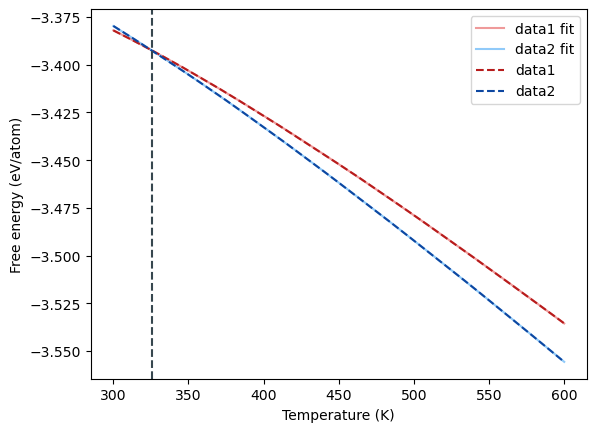

(326.0, None)

In [106]:
import pyiron_nodes

from pyiron_nodes.atomistic.property import calphy as pn_calphy
# Without this, when I try to reference pyiron_nodes.atomistic.property.calphy.X`, I get
# AttributeError: module 'pyiron_nodes.atomistic.property' has no attribute 'calphy'
# This must just be something with the init files not registering modules nicely over in pyiron_nodes
# My notebook is highlighting `property` as a python keyword, so maybe there is some conflict that 
# confuses things?
# Still, we never need to actually use pn_calphy, just completing the import is enough


wf = Workflow('calphy2')

element = "Al"
cell_size = 3
solid_fraction = 0

wf.CubicBulkCell = pyiron_nodes.atomistic.structure.build.CubicBulkCell(element=element, cell_size=cell_size) 
wf.Potential = pyiron_nodes.atomistic.engine.lammps.Potential(structure=wf.CubicBulkCell) 

wf.Tolerance = pyiron_nodes.atomistic.property.calphy.Tolerance(solid_fraction=solid_fraction) 
wf.InputClass = pyiron_nodes.atomistic.property.calphy.InputClass() 
wf.InputClass_1 = pyiron_nodes.atomistic.property.calphy.InputClass(tolerance=wf.Tolerance) 
wf.SolidFreeEnergyWithTemperature = pyiron_nodes.atomistic.property.calphy.SolidFreeEnergyWithTemperature(structure=wf.CubicBulkCell, potential=wf.Potential, inp=wf.InputClass_1, store=False) 
wf.LiquidFreeEnergyWithTemperature = pyiron_nodes.atomistic.property.calphy.LiquidFreeEnergyWithTemperature(potential=wf.Potential, structure=wf.CubicBulkCell, inp=wf.InputClass, store=False) 
wf.CalculatePhaseTransformationTemperature = pyiron_nodes.atomistic.property.calphy.CalculatePhaseTransformationTemperature(t1=wf.SolidFreeEnergyWithTemperature.outputs.t, 
                                                                                                                            f1=wf.SolidFreeEnergyWithTemperature.outputs.f, 
                                                                                                                            t2=wf.LiquidFreeEnergyWithTemperature.outputs.t, 
                                                                                                                            f2=wf.LiquidFreeEnergyWithTemperature.outputs.f) 

wf.CalculatePhaseTransformationTemperature.pull()

# ValueError: Was not able to locate the potential files in ResolverChain(ResourceResolver([], 'lammps''potentials'), ResourceResolver(['/Users/liamhuber/dev/miniforge3/envs/pycor12'], 'share''iprpy'))!
# Looks like we need to include some potentials in the repo

In [107]:
from pyiron_workflow.graph.base import get_full_graph_from_wf, get_updated_graph, pull_node, _load_graph

In [108]:
# graph = full_graph = get_full_graph_from_wf(wf)
graph = _load_graph("calphy2.json")
pull_node(get_updated_graph(graph), "LiquidFreeEnergyWithTemperature")

AttributeError: 'NoneType' object has no attribute 'items'

In [110]:
graph.nodes

,id,import_path,label,parent_id,level,node,graph,node_type,widget_type,expanded
0,Bulk,pyiron_nodes.atomistic.structure.build.Bulk,Bulk,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
1,ThreadPoolExecutor,pyiron_nodes.executors.ThreadPoolExecutor,ThreadPoolExecutor,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
2,SingleNodeExecutor,pyiron_nodes.executors.SingleNodeExecutor,SingleNodeExecutor,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
3,Linspace,pyiron_nodes.math.Linspace,Linspace,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
4,Volume,pyiron_nodes.atomistic.structure.calc.Volume,Volume,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False
5,IterNode,pyiron_nodes.executors.IterNode,IterNode,None,0,<pyiron_workflow.simple_workflow.Node object a...,None,node,customNode,False


critical feature:
- executorlib must be able to run single node or (sub)-workflow
- executorlib is a task manager (not a workflow executor)
- library stack:
    - workflow_creator
    - workflow_executor
    - executor_lib
- application:
    - exec.submit(node)  

In [ ]:
from pyiron_workflow import as_macro_node


@as_macro_node("transition_temperature")
def calphy2(element: str, cell_size: int = 1, solid_fraction: float = 0.7):

    from pyiron_workflow import Workflow
    import pyiron_nodes

    wf = Workflow('calphy2')

    wf.CubicBulkCell = pyiron_nodes.atomistic.structure.build.CubicBulkCell(element=element, cell_size=cell_size) 
    wf.Tolerance = pyiron_nodes.atomistic.property.calphy.Tolerance(solid_fraction=solid_fraction) 
    wf.InputClass = pyiron_nodes.atomistic.property.calphy.InputClass() 
    wf.Potential = pyiron_nodes.atomistic.engine.lammps.Potential(structure=wf.CubicBulkCell) 
    wf.InputClass_1 = pyiron_nodes.atomistic.property.calphy.InputClass(tolerance=wf.Tolerance) 
    wf.LiquidFreeEnergyWithTemperature = pyiron_nodes.atomistic.property.calphy.LiquidFreeEnergyWithTemperature(potential=wf.Potential, structure=wf.CubicBulkCell, inp=wf.InputClass) 
    wf.SolidFreeEnergyWithTemperature = pyiron_nodes.atomistic.property.calphy.SolidFreeEnergyWithTemperature(structure=wf.CubicBulkCell, potential=wf.Potential, inp=wf.InputClass_1) 
    wf.CalculatePhaseTransformationTemperature = pyiron_nodes.atomistic.property.calphy.CalculatePhaseTransformationTemperature(t1=wf.SolidFreeEnergyWithTemperature.outputs.t, f1=wf.SolidFreeEnergyWithTemperature.outputs.f, t2=wf.LiquidFreeEnergyWithTemperature.outputs.t, f2=wf.LiquidFreeEnergyWithTemperature.outputs.f) 

    return wf.CalculatePhaseTransformationTemperature# .outputs.transition_temp #, wf.CalculatePhaseTransformationTemperature.outputs.plot

    

It appears that macro of a macro does not work
- check!!

In [ ]:
@as_macro_node("transition_temperature")
def calphy2(element: str, cell_size: int = 1, solid_fraction: float = 0.7):

    from pyiron_workflow import Workflow
    import pyiron_nodes

    wf = Workflow('calphy2')

    # wf.CubicBulkCell = pyiron_nodes.atomistic.structure.build.Bulk("Al") # CubicBulkCell(element=element, cell_size=cell_size) 
    wf.CubicBulkCell = pyiron_nodes.atomistic.structure.build.CubicBulkCell(element=element, cell_size=cell_size)

    return wf.CubicBulkCell

In [ ]:
graph = base.Graph()
graph += pyiron_nodes.atomistic.structure.build.CubicBulkCell(element="Al")
graph.nodes

In [ ]:
from pyiron_workflow.graph import base

n = calphy2(element="Al")
graph = base.get_graph_from_macro_node(n)
# base.run_macro_node(n)
# base.GuiGraph(base.get_graph_from_macro_node(n))
# base.get_graph_from_macro_node(n).nodes["CubicBulkCell"].node.run()
graph.nodes

In [ ]:
import pyiron_nodes as pn

In [ ]:
from typing import Optional

@as_macro_node("structure")
def CubicBulkCell(
    element: str, cell_size: int = 1, vacancy_index: Optional[int] = None
):
    from pyiron_nodes.atomistic.structure.build import Bulk
    from pyiron_nodes.atomistic.structure.transform import (
        CreateVacancy,
        Repeat,
    )
    from pyiron_workflow import Workflow

    wf = Workflow('macro')

    wf.bulk = Bulk(name=element, cubic=True)
    wf.repeat = Repeat(structure=wf.bulk, repeat_scalar=cell_size)

    wf.vacancy = CreateVacancy(structure=wf.repeat, index=vacancy_index)
    return wf.vacancy

In [ ]:
CubicBulkCell("Al").run()

In [ ]:
pn.atomistic.structure.build.CubicBulkCell(element="Al")

In [ ]:
from executorlib import SingleNodeExecutor

In [ ]:
%%time
with SingleNodeExecutor(max_workers=4, block_allocation=True) as exe:
    future_lst = [exe.submit(sum, [i, i]) for i in range(2, 5)]
    print([f.result() for f in future_lst])

In [ ]:
import concurrent.futures
import math

PRIMES = [
    112272535095293,
    112582705942171,
    112272535095293,
    115280095190773,
    115797848077099,
    1099726899285419]

def is_prime(n):
    if n < 2:
        return False
    if n == 2:
        return True
    if n % 2 == 0:
        return False

    sqrt_n = int(math.floor(math.sqrt(n)))
    for i in range(3, sqrt_n + 1, 2):
        if n % i == 0:
            return False
    return True




In [ ]:
%%time
with SingleNodeExecutor(max_workers=6, block_allocation=False) as exe:
    future_lst = [exe.submit(is_prime, n) for n in PRIMES]
    print([f.result() for f in future_lst])

In [ ]:
%%time
with SingleNodeExecutor(max_workers=1, block_allocation=True) as exe:
    future_lst = [exe.submit(pn.atomistic.structure.build.Bulk()._func, n) for n in ["Al", "Fe", "Ni", "Zn"]]
    print([f.result() for f in future_lst])

In [ ]:
Al = pn.atomistic.structure.build.Bulk()._func('Al')
Al.species[0].name

In [ ]:
%%time
for n in ["Al", "Fe"]:
    print(pn.atomistic.structure.build.Bulk(n).run())

In [ ]:
import pyiron_nodes as pn
import concurrent.futures
import urllib.request

elements = ['Al', 'Fe']


# We can use a with statement to ensure threads are cleaned up promptly
with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
    # Start the load operations and mark each future with its URL
    futures = {executor.submit(pn.atomistic.structure.build.Bulk()._func, el, **{'cubic': True}): el for el in elements}
    for future in concurrent.futures.as_completed(futures):
        out = futures[future]
        print("out: ", out)

        data = future.result()
        print(data.__repr__())

In [ ]:
from pyiron_workflow import as_function_node, Node

@as_function_node
def IterNode(node: Node, kwarg_name: str, kwarg_list: list, max_workers: int=1, executor=None):
    # from concurrent.futures import ThreadPoolExecutor as Executor
    from executorlib import SingleNodeExecutor as Executor
    from concurrent.futures import as_completed

    out_dict = dict()
    with Executor(max_workers=max_workers) as executor:
        # Start the load operations and mark each future with its index
        futures = {executor.submit(node._func, **{kwarg_name: el}): el for el in kwarg_list}
        for future in as_completed(futures):
            out = futures[future]    
            data = future.result()
            out_dict[out] = data.species[0].name
            
            # print("out: ", out)
            # print(data.__repr__())
            
    return out_dict
    

In [ ]:
%%time
elements = ['Al', 'Fe']

IterNode(pn.atomistic.structure.build.Bulk(), "name", elements, max_workers=2).run()

In [ ]:
import numpy as np

# Define the matrix mat and the index array ind1
mat = np.array([[0, 1, 2],
                [3, 4, 5],
                [6, 7, 8]])

ind1 = np.array([1, 0, 2])

# Compute v using advanced indexing
v = mat[ind1, np.arange(len(ind1))]

v  # Output: [3, 1, 8]

In [ ]:
import pyiron_nodes as pn

n = pn.atomistic.structure.build.Bulk("Al")

In [ ]:
kwargs = n.kwargs
kwargs.update({"a": 2.1})
kwargs

In [ ]:
# CLEANUP

subprocess.run(["../../local_postgres.zsh", "stop"])
subprocess.run(["../../local_postgres.zsh", "remove"])

for name in json_files:
    with contextlib.suppress(FileNotFoundError):
        (pathlib.Path(".") / name).unlink()